In [22]:
# Importar bibliotecas
import cv2 as cv
import numpy as np
import random

In [23]:
def get_contour_of_tray():   
    tray_contour=[[[389,  34]],[[108,  40]],
       [[113, 248]],[[386, 235]]]
    return np.asarray(tray_contour)

In [24]:
def limpar_ruido(image):
    new_img=image.copy()
    new_img = cv.cvtColor(new_img, cv.COLOR_BGR2GRAY)
    new_img = cv.fastNlMeansDenoising(new_img,None,20,7,21)
    # create a CLAHE object (Arguments are optional).
    clahe = cv.createCLAHE(clipLimit=7.0, tileGridSize=(8,8))
    new_img = clahe.apply(new_img)
    # Threshold image
    ret, thresh = cv.threshold(new_img, 100, 255, cv.THRESH_BINARY_INV)
    # Efeito de Blur
    #new_img = cv.GaussianBlur(new_img, (25, 25), 0)
    return thresh

In [25]:
def find_more_similar_contour(contours,template_contour):
    try:
        match_value =[] 
        area=cv.contourArea(template_contour)
        threshold=0.1*area
        for (i,contour) in enumerate(contours):
            temp_area=cv.contourArea(contour)
            if abs(temp_area-area)<threshold:
                # Iterate through each contour in the target image and 
                # use cv.matchShapes to compare contour shapes
                match = cv.matchShapes(template_contour, contour, 1, 0.0)
                match_value.append([contour,match])
                #print(match)
        match_value=sorted(match_value, key = 
                    lambda kv:(kv[1]),reverse=False)
        return match_value[0]
    except:
        return None

In [26]:
def salva_img_contorno(image,contour,output_file_name):
    (x, y, w, h) = cv.boundingRect(contour)  
    # Let's now crop each contour and save these images
    cropped_contour = image[y:y + h, x:x + w]
    cv.imwrite(output_file_name, cropped_contour)

In [27]:
#Exibe imagem
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def plot_image(image,title=''):
    fig=plt.figure()
    fig.suptitle(title, fontsize=20)
    plt.imshow(image,cmap=cm.gray)
    plt.axis("off")
    plt.show()


In [28]:
#Carregar image para analisar
image = cv.imread("./data/2.png")
new_image=limpar_ruido(image)

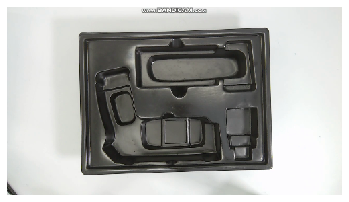

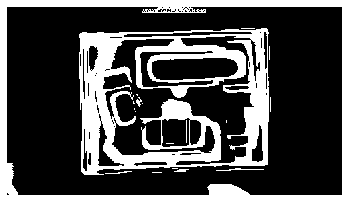

In [29]:
#Exibi imagem original e a tratada apos a limpeza de ruido
plot_image(image)
plot_image(new_image)

### Exemplo para encontrar todos os contornos e salvar em arquivo para descobrir qual o da bandeja

Quantity contours:  19


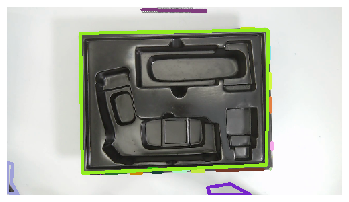

In [30]:
#Computa contorno apos imagem tratada e realiza calculo de aproximação de poligono
im2, contours, hierarchy = cv.findContours(new_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
print('Quantity contours: ',len(contours))
temp=image.copy()
for (i,contour) in enumerate(contours):
    
    rgb = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
    
    accuracy = 0.03 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, accuracy, True)
    contour=approx    
    #print(i,cv.contourArea(approx))
        
    cv.drawContours(temp, [approx], -3, rgb, 3)

plot_image(temp)

In [31]:
#Ordena contornos pela a area
sorted_contours = sorted(contours, key=cv.contourArea, reverse=True)
#Salva a imagem contida nos contornos
for (i,contour) in enumerate(sorted_contours):
    output_file_name='contour_{}.jpg'.format(i)
    salva_img_contorno(image,contour,output_file_name)
print('Contours in sorted save')

Contours in sorted save


In [11]:
#Recupera contorno de index 0
np.set_printoptions(threshold=np.inf)
teste=sorted_contours[0]
#Calcula aproximação de poligono
accuracy = 0.03 * cv.arcLength(teste, True)
approx = cv.approxPolyDP(teste, accuracy, True)
#Compara array do contorno com o apos a aproximado
print(len(teste),len(approx),approx)

1180 4 [[[389  35]]

 [[109  40]]

 [[112 248]]

 [[387 236]]]


### Buscar dentre todos os contorno da imagem o poligono que representa a bandeja e salvar como arquivo target

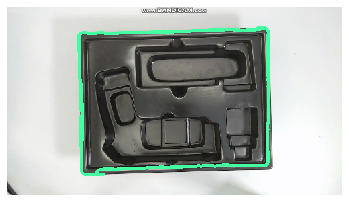

In [12]:
tray=get_contour_of_tray()
output_file_name='target.jpg'
contour_found=find_more_similar_contour(contours,tray)
temp=image.copy()
cv.drawContours(temp, contour_found[0], -3, rgb, 3)
plot_image(temp)
#salva_img_contorno(image,contour_found[0],output_file_name)

In [32]:
def detect_contours(image):
    new_image=limpar_ruido(image)
    #Computa contorno apos imagem tratada e realiza calculo de aproximação de poligono
    im2, contours, hierarchy = cv.findContours(new_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    print('Quantity contours: ',len(contours))
    return contours

In [39]:
def detect_tray(file_name,i):
    other_image = cv.imread(file_name)
    contours=detect_contours(other_image)
    contour_found=find_more_similar_contour(contours,get_contour_of_tray())
    if contour_found != None:
        cv.drawContours(other_image, contour_found[0], -3, [0,255,0], 3)
        plot_image(other_image,file_name)
        output_file_name="bandeja_{}.png".format(i)
        salva_img_contorno(other_image,get_contour_of_tray(),output_file_name)
    else:
        print('Bandeja não encontrada na imagem ')
        plot_image(other_image,file_name)

Quantity contours:  18
Bandeja não encontrada na imagem 


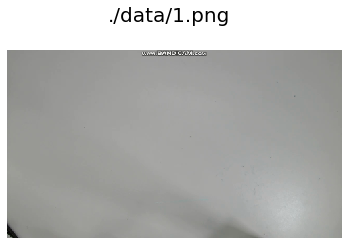



Quantity contours:  19


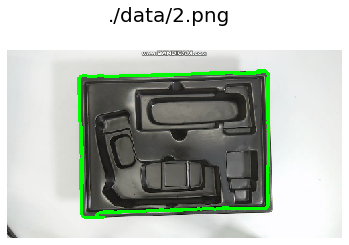



Quantity contours:  13


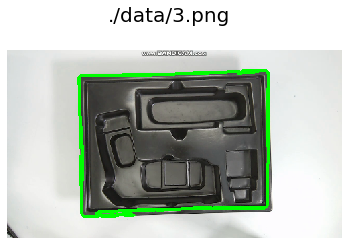



Quantity contours:  18


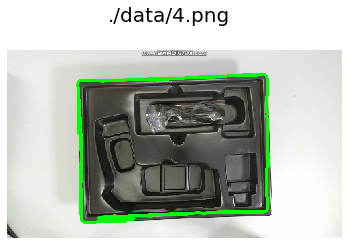



Quantity contours:  17


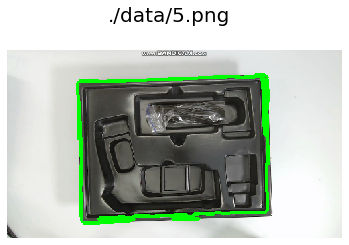



Quantity contours:  16


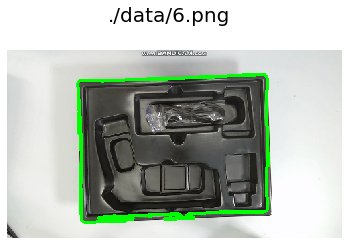



Quantity contours:  21


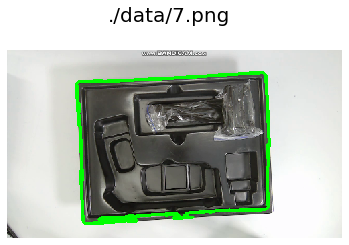



Quantity contours:  25


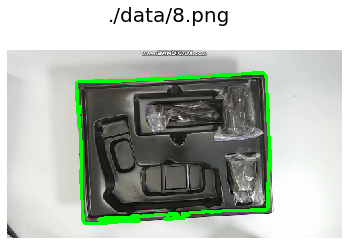



Quantity contours:  26


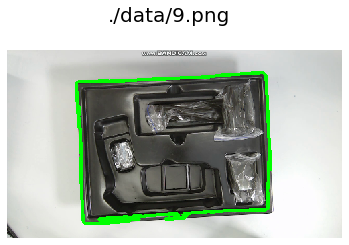



Quantity contours:  16


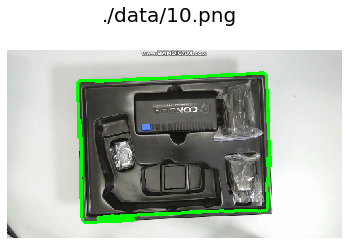



Quantity contours:  22


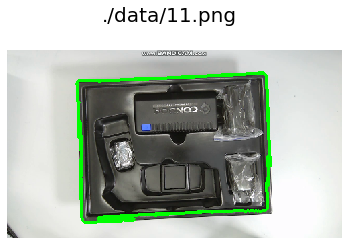



Quantity contours:  20


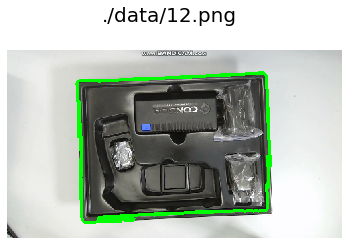



Quantity contours:  10


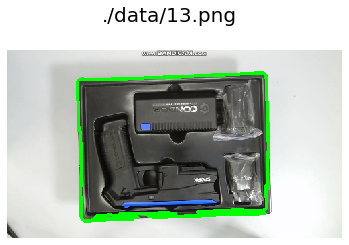



Quantity contours:  12


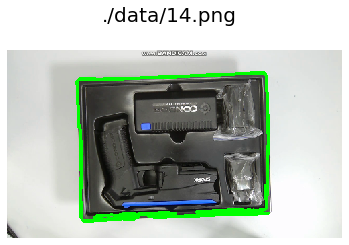



Quantity contours:  19
Bandeja não encontrada na imagem 


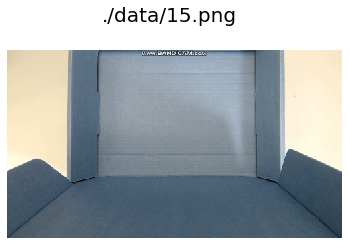



Quantity contours:  30
Bandeja não encontrada na imagem 


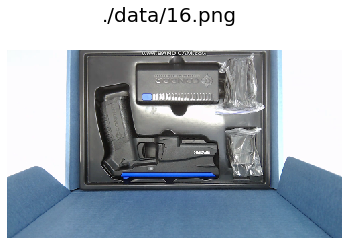



Quantity contours:  43
Bandeja não encontrada na imagem 


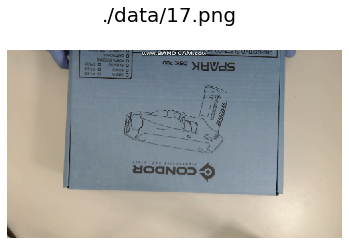

In [40]:
for i in range(1,18):
    detect_tray("./data/{}.png".format(i),i)
    print('\n')